# 난 스케치를 할 테니 넌 채색을 하거라 프로젝트


## 1_GAN vs cGAN

- mnist dataset

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /aiffel/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


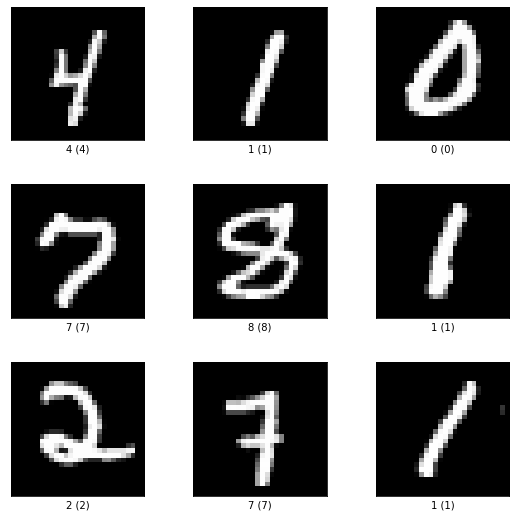

In [1]:
# 데이터 준비

import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

✅


Label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


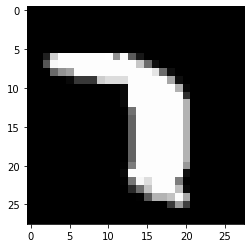

In [3]:
#숫자 레이블이 일치하는지, 이미지값의 범위가 -1,1사이인지 확인 

import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

## generator 구성

In [4]:
# GAN Generator를 만들어주세요.

from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        # 활성화함수를 'relu'를 사용하고 unit이 128인 Dense Layer를 정의해주세요,.
        self.dense_1 = layers.Dense(128, activation='relu')
        # 활성화함수를 'relu'를 사용하고 unit이 256인 Dense Layer를 정의해주세요.
        self.dense_2 = layers.Dense(256, activation='relu')
        # 활성화함수를 'relu'를 사용하고 unit이 512인 Dense Layer를 정의해주세요.
        self.dense_3 = layers.Dense(512, activation='relu')
        # 활성화함수를 하이퍼볼릭 탄젠트를 사용하고 unit이 784인 Dense Layer를 정의해주세요.
        self.dense_4 = layers.Dense(784, activation='tanh')
        # 모양일 (28,28,1)로 변경해주세요.
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

In [8]:
#cGAN Generator를 만들어주세요.

class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        # 노이즈에 Dense layer를 적용시킵니다.
        noise = self.dense_z(noise)
         # 라벨에 Dense layer를 적용시킵니다.
        label = self.dense_y(label)
        # 노이즈와 라벨을 pair가 되게 합친 다음 combined_dense를 적용시킵니다. (힌트 : https://www.tensorflow.org/api_docs/python/tf/concat)
        out = self.combined_dense(layers.Concatenate()([noise, label]))
        # 마지막 Dense Layer를 적용시킵니다.
        out = self.final_dense(out)
        return self.reshape(out)

## Discriminator 구성

In [12]:
# GAN Discriminator를 만들어주세요.

class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        #해당 방식은 반복문을 활용해 layer를 쌓기 때문에 좋은 테크닉중 하나입니다,.
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    

In [6]:
# maxout 구성 - cGAN discriminator에서 사용되는 layer
#곡선형태의 activation function을 만들어 내는 역할을 떠올려보기
#두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오는 것.

# units 차원 수를 가진 fully-connected 레이어를 pieces개 만큼 만들고 그 중 최대 값을 출력
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)


In [9]:
#cGAN의 discriminator 구성

class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)

## 학습 및 테스트

In [10]:
# 이진 분류 -> binary cross entropy

from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

# optimizer => adam
gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4) 

In [13]:
# GAN 모델 + 하나의 배치 크기 데이터로 모델 업데이트하는 함수 구현

gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    #100차원의 노이즈
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

In [14]:
#10 에포크 학습

EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.0538370609283447, D:0.15976013243198395
[1/10 EPOCHS, 200 ITER] G:2.783520221710205, D:0.09687446802854538
[1/10 EPOCHS, 300 ITER] G:2.4877424240112305, D:0.1250368058681488
[1/10 EPOCHS, 400 ITER] G:2.352027177810669, D:0.1703677624464035
[2/10 EPOCHS, 100 ITER] G:3.4398350715637207, D:0.15180963277816772
[2/10 EPOCHS, 200 ITER] G:2.9896609783172607, D:0.17053711414337158
[2/10 EPOCHS, 300 ITER] G:2.7599141597747803, D:0.1397940069437027
[2/10 EPOCHS, 400 ITER] G:3.791350841522217, D:0.08805815130472183
[3/10 EPOCHS, 100 ITER] G:4.010547637939453, D:0.1478784829378128
[3/10 EPOCHS, 200 ITER] G:4.810549736022949, D:0.12112370133399963
[3/10 EPOCHS, 300 ITER] G:3.187976837158203, D:0.13296309113502502
[3/10 EPOCHS, 400 ITER] G:4.673014163970947, D:0.03305027261376381
[4/10 EPOCHS, 100 ITER] G:3.4876036643981934, D:0.24196358025074005
[4/10 EPOCHS, 200 ITER] G:3.5982754230499268, D:0.13598662614822388
[4/10 EPOCHS, 300 ITER] G:4.028935432434082, D:0.0787788480

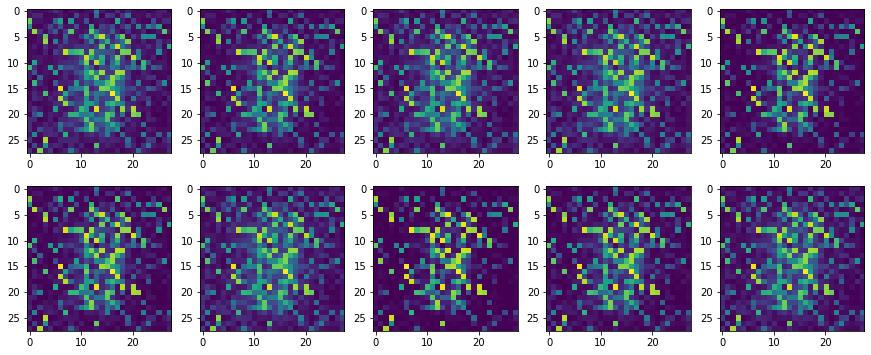

In [15]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

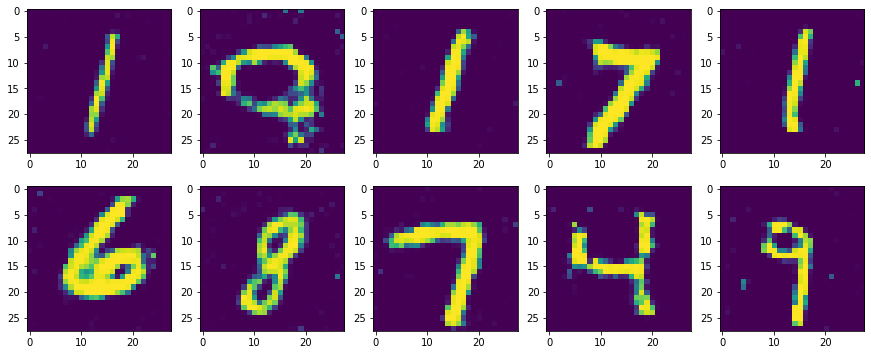

In [16]:
# 10에포크가 아닌 500에포크로 학습한 가중치의 모델 가져오기

import os
weight_path = os.getenv('HOME')+'/aiffel/workspace/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

In [21]:
# cGAN 모델 + 하나의 배치 크기 데이터로 모델 업데이트하는 함수 구현

cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    #100차원의 노이즈
    noise = tf.random.normal([real_images.shape[0], 100])

    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = cgan_generator(noise, labels)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss

In [23]:
# 에포크 1로 학습. 100번의 반복마다 loss를 출력

EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 100 ITER] G:5.151601791381836, D:0.023950252681970596
[1/1 EPOCHS, 200 ITER] G:3.710986852645874, D:0.0805889368057251
[1/1 EPOCHS, 300 ITER] G:3.616539478302002, D:0.14945626258850098
[1/1 EPOCHS, 400 ITER] G:3.059600830078125, D:0.33256611227989197


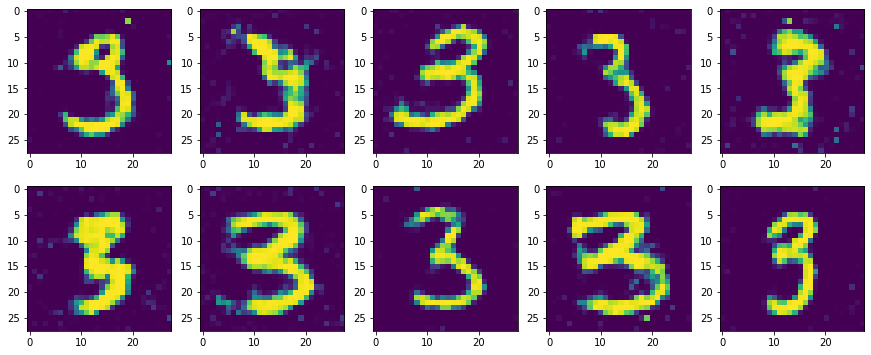

In [24]:
#생성할 숫자 입력
number =  3

weight_path = os.getenv('HOME')+'/aiffel/workspace/conditional_generation/cgan/CGAN_500'

# 100차원의 노이즈 10개 array
noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

# 2_Pix2Pix - 입력에 이미지를 넣자!

이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델

conditional adversarial networks로 img to img translation을 수행한다.

-> 어떠한 이미지를 입력받아 변환된 이미지를 출력하기 위해 generator를 사용하는데, encoder - decoder의 구조를 갖는다.

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/workspace/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


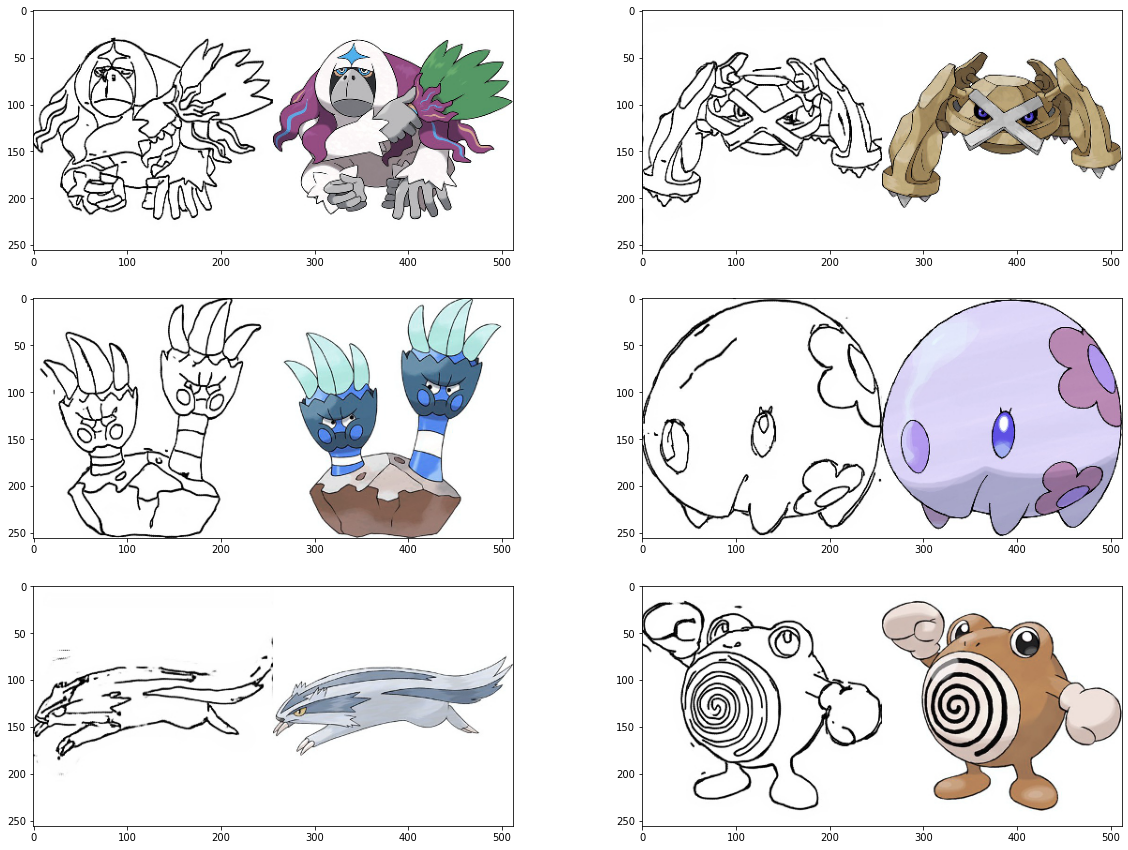

In [2]:
#(256,256)이 나란히 있는 256,512크기의 이미지 데이터가 830장 (스케치 + 실제 모습)
#그중에서 몇 개만 예시 보기

import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


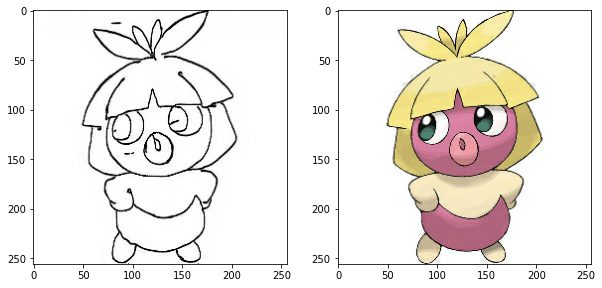

In [4]:
# 256,256,3의 크기 2개 이미지로 분할해보기

import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [5]:
#data augmentation

#두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
#1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
#2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
#3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
#4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
#5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   


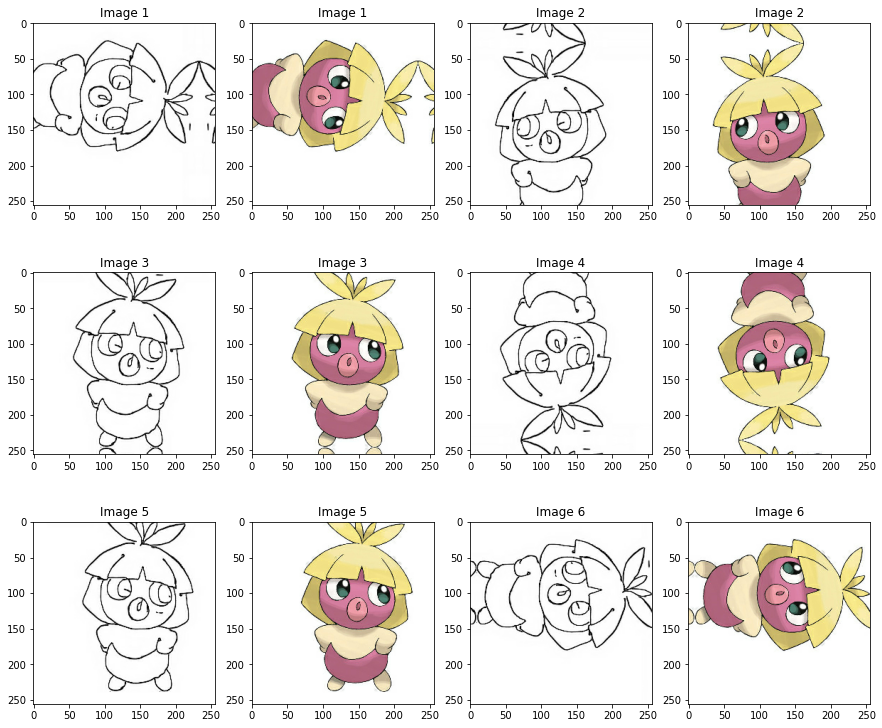

In [6]:
#증강을 적용한 이미지 시각화

plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

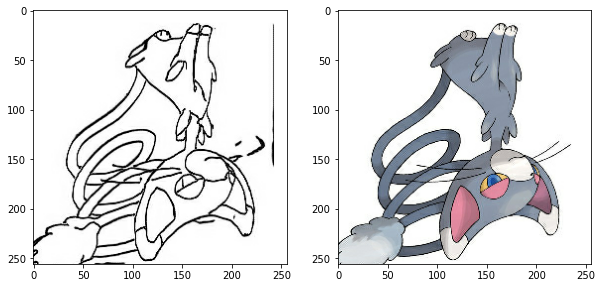

In [7]:
#학습 데이터에 증강 적용하고 그 중 하나만 시각화 해보기

from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

##  3_pix2pix 구현 for generator

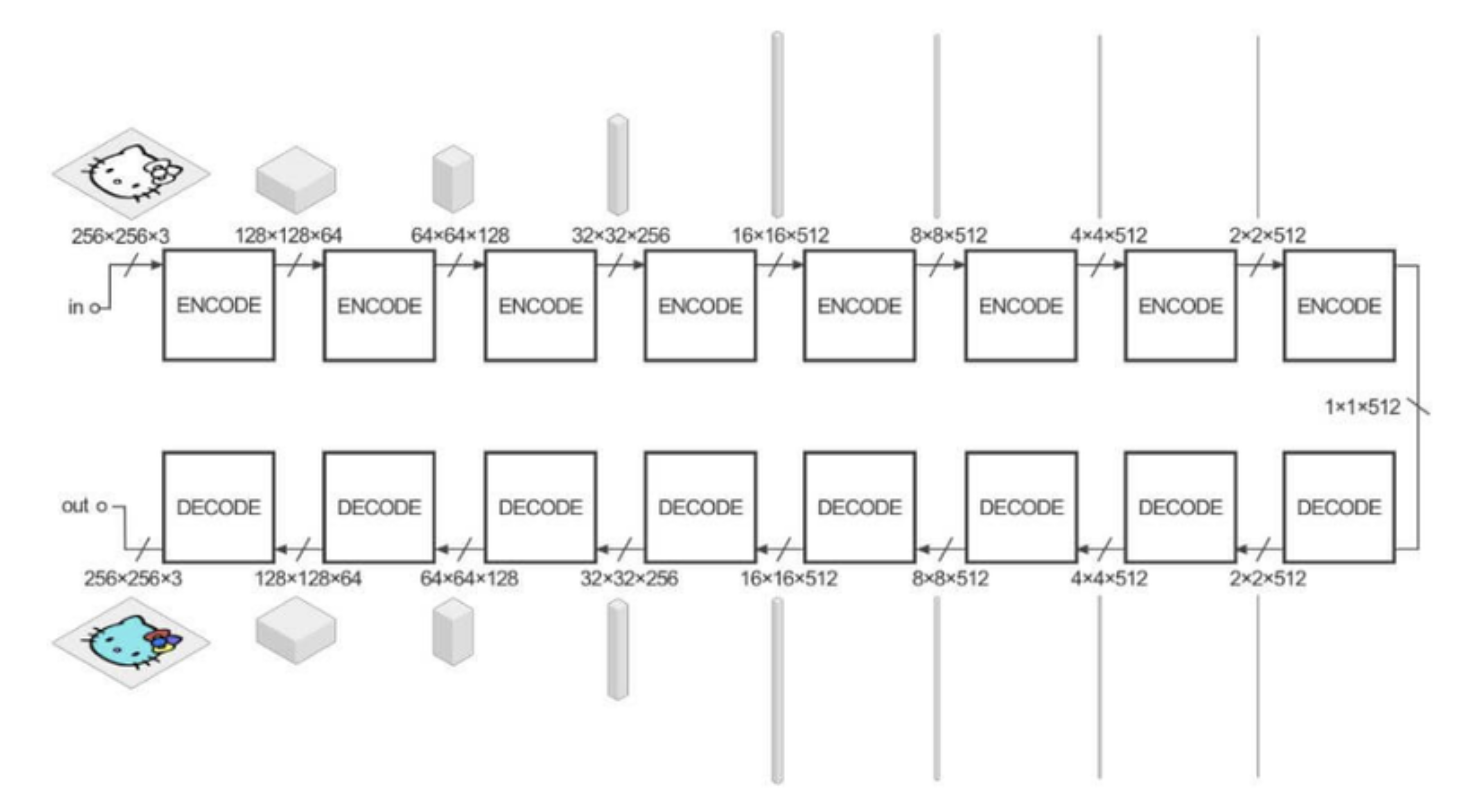



### encode subclassing

In [8]:
#encode

from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [9]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [10]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

## decode subclassing

In [11]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        self.blocks = []
        
        # 조건 1. 3번째 block까지는 Dropout을 사용하되 그 이후에는 Dropout을 사용하지 마세요.
        # for문이 끝난 다음 Conv2DTranspose를 쌓아주되 output 차원수는 3, filter 사이즈는 4, stride는 2로 구성해주시고 자동 패딩 적용해주시되 bias는 사용하지 않습니다.
        for i, f in enumerate(filters):
            if i <= 2:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout = False))
        self.blocks.append(layers.Conv2DTranspose(3,4,2,"same", use_bias = False))
        
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [12]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [13]:
# encoder 와 decoder를 연결하여 generator 구성하기

class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## encoder - decoder 구조를 수정하여 u-net구조로 바꾸기(성능 향상)

In [17]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        #encoder 마지막 출력 제외
        features = features[:-1]
        
        #대칭적 구조를 위한 feature 역순 concatenate
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [19]:
UNetGenerator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_24 (EncodeBlock)   (None, 128, 128, 64) 3072        input_5[0][0]                    
__________________________________________________________________________________________________
encode_block_25 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_24[0][0]            
__________________________________________________________________________________________________
encode_block_26 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_25[0][0]            
____________________________________________________________________________________________

## 4_pix2pix 구현 for discriminator

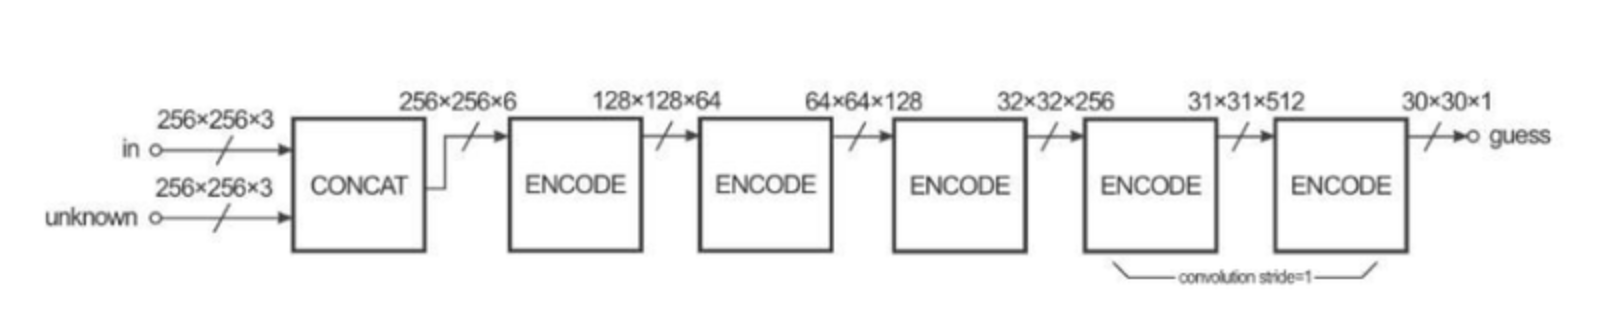

In [20]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [21]:
#출력 크기 확인용
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_60 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [23]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]

        for i, f in enumerate(filters):
            self.blocks.append(DiscBlock(n_filters=f,
            stride=2 if i<3 else 1,
            custom_pad=False if i<3 else True,
            use_bn=False if i==0 and i==4 else True,
            act=True if i<4 else False))

        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")

    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [24]:
Discriminator().get_summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 256, 256, 6)  0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
disc_block_5 (DiscBlock)        (None, 128, 128, 64) 6144        concatenate_15[0][0]       

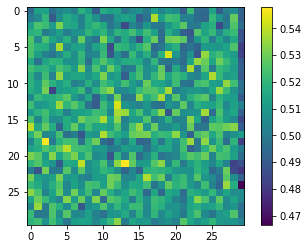

In [25]:
#임의의 256,256,3 입력 -> 30,30 출력 시각화

x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 이해가 안되는 부분1: (해결)
이전 PatchGAN에 대해 설명했던 것처럼, 위 (30,30) 크기를 갖는 결과 이미지의 각 픽셀 값은 원래 입력의 (70,70) 패치에 대한 분류 결과입니다. 전체 입력의 크기가 (256,256) 이므로, 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있겠죠. 각각의 픽셀 값은 sigmoid 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해 내는 데 사용합니다.

In [26]:
## pix2pix 학습 및 테스트

In [27]:
#loss function -> L1 + cGAN

from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [28]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [34]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
        
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [35]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8909                     
L1_loss:0.5133                     
Discriminator_loss:1.2470

EPOCH[1] - STEP[20]                     
Generator_loss:0.7142                     
L1_loss:0.3345                     
Discriminator_loss:1.3912

EPOCH[1] - STEP[30]                     
Generator_loss:0.9035                     
L1_loss:0.3026                     
Discriminator_loss:1.1146

EPOCH[1] - STEP[40]                     
Generator_loss:1.2666                     
L1_loss:0.2901                     
Discriminator_loss:1.0843

EPOCH[1] - STEP[50]                     
Generator_loss:1.2645                     
L1_loss:0.2056                     
Discriminator_loss:0.7875

EPOCH[1] - STEP[60]                     
Generator_loss:1.6237                     
L1_loss:0.2372                     
Discriminator_loss:0.6415

EPOCH[1] - STEP[70]                     
Generator_loss:1.7114                     
L1_loss:0.2377                    

EPOCH[3] - STEP[170]                     
Generator_loss:1.9458                     
L1_loss:0.2659                     
Discriminator_loss:0.9789

EPOCH[3] - STEP[180]                     
Generator_loss:2.1449                     
L1_loss:0.2858                     
Discriminator_loss:0.4237

EPOCH[3] - STEP[190]                     
Generator_loss:0.1238                     
L1_loss:0.2458                     
Discriminator_loss:2.5063

EPOCH[3] - STEP[200]                     
Generator_loss:2.0848                     
L1_loss:0.2410                     
Discriminator_loss:0.5615

EPOCH[4] - STEP[10]                     
Generator_loss:1.4962                     
L1_loss:0.2564                     
Discriminator_loss:0.4374

EPOCH[4] - STEP[20]                     
Generator_loss:1.0906                     
L1_loss:0.2802                     
Discriminator_loss:0.6243

EPOCH[4] - STEP[30]                     
Generator_loss:1.4243                     
L1_loss:0.2560                

EPOCH[6] - STEP[130]                     
Generator_loss:2.6656                     
L1_loss:0.2311                     
Discriminator_loss:1.4007

EPOCH[6] - STEP[140]                     
Generator_loss:0.8248                     
L1_loss:0.2258                     
Discriminator_loss:1.1164

EPOCH[6] - STEP[150]                     
Generator_loss:0.7075                     
L1_loss:0.2012                     
Discriminator_loss:1.1417

EPOCH[6] - STEP[160]                     
Generator_loss:3.7797                     
L1_loss:0.2599                     
Discriminator_loss:1.8161

EPOCH[6] - STEP[170]                     
Generator_loss:3.8780                     
L1_loss:0.2725                     
Discriminator_loss:0.2838

EPOCH[6] - STEP[180]                     
Generator_loss:1.1304                     
L1_loss:0.2488                     
Discriminator_loss:0.4857

EPOCH[6] - STEP[190]                     
Generator_loss:0.5737                     
L1_loss:0.2160             

EPOCH[9] - STEP[90]                     
Generator_loss:3.3609                     
L1_loss:0.2612                     
Discriminator_loss:0.4970

EPOCH[9] - STEP[100]                     
Generator_loss:1.8246                     
L1_loss:0.2436                     
Discriminator_loss:0.3884

EPOCH[9] - STEP[110]                     
Generator_loss:2.4369                     
L1_loss:0.2884                     
Discriminator_loss:0.2225

EPOCH[9] - STEP[120]                     
Generator_loss:0.9384                     
L1_loss:0.2115                     
Discriminator_loss:0.7234

EPOCH[9] - STEP[130]                     
Generator_loss:2.5820                     
L1_loss:0.2492                     
Discriminator_loss:1.1368

EPOCH[9] - STEP[140]                     
Generator_loss:3.2383                     
L1_loss:0.2437                     
Discriminator_loss:0.6274

EPOCH[9] - STEP[150]                     
Generator_loss:2.7120                     
L1_loss:0.2394              

In [ ]:
#색칠하기

test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))